<a href="https://colab.research.google.com/github/zia207/r-colab/blob/main/NoteBook/Advance_Regression/02-04-03-04-multilevel-glm-poisson-r.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

![alt text](http://drive.google.com/uc?export=view&id=1bLQ3nhDbZrCCqy_WCxxckOne2lgVvn3l)

# 3.4. Mutilevel or Mixed Effect Poisson Model (MLPM)

Multi-level count data is commonly found in ecology, epidemiology, and social sciences, representing occurrences like disease cases or animal sightings. When this data is clustered or hierarchical, mixed-effects Poisson models offer a robust analytical framework. This tutorial provides an overview of mixed-effects Poisson models for count data and step-by-step instructions for fitting these models in R, highlighting the underlying principles. We will also explore several R packages, including {lme4}, {glmmTMB}, and {MASS}, to fit various Poisson models, with a particular emphasis on managing overdispersion using quasi-Poisson and negative binomial models. By the end of this tutorial, readers will gain theoretical knowledge and practical skills to analyze count data effectively, enabling informed, data-driven decision-making.


## Overview

A **mixed-effects Poisson model** is a type of regression model used to analyze count data while accounting for both fixed effects (effects that are constant across observations) and random effects (effects that vary across groups or clusters). This model is widely used in fields such as biostatistics, epidemiology, and ecology to analyze data with hierarchical or clustered structures.

***Model Description***:

The general form of a mixed-effects Poisson model can be written as:

$$ Y_{ij} \sim \text{Poisson}(\lambda_{ij}) $$ where:

-   $Y_{ij}$ is the observed count for the $i$-th observation in the $j$-th group.

-   $\lambda_{ij}$ is the expected count (mean) for the $i$-th observation in the $j$-th group.

The expected count, $\lambda_{ij}$, is linked to a linear predictor via a **log-link function**:

$$ \log(\lambda_{ij}) = X_{ij}^T \beta + Z_j^T u_j $$ where:

-   $X_{ij}$ is a vector of fixed-effect covariates for the $i$-th observation in the $j$-th group.

-   $\beta$ is the vector of fixed-effect coefficients (parameters).

-   $Z_j$ is a vector of random-effect covariates associated with the $j$-th group.

-   $u_j$ is the random-effect vector for the $j$-th group, typically assumed to follow a multivariate normal distribution: $u_j \sim N(0, \Sigma_u)$.

***Key Components***:

1.  **Fixed Effects** ($X_{ij}^T \beta$):

    -   Represent the population-level effects that are consistent across all groups.
    -   For example, the effect of a treatment or other covariates like age or gender.

2.  **Random Effects** ($Z_j^T u_j$):

    -   Capture the group-specific variability.
    -   Allow for the inclusion of cluster-level heterogeneity.

3.  **Poisson Assumption**:

    -   The response variable $Y_{ij}$ is assumed to follow a Poisson distribution with mean $\lambda_{ij}$.
    -   Variance equals the mean in a standard Poisson model, but overdispersion (variance greater than the mean) can be handled by extending the model (e.g., using a negative binomial distribution).

***Complete Model Equation***:

$$ \log(\lambda_{ij}) = \beta_0 + \sum_{k=1}^p \beta_k X_{ijk} + \sum_{m=1}^q u_{jm} Z_{ijm} $$

where:

-   $\beta_0$ is the intercept.
-   $\beta_k$ are fixed-effect coefficients for covariates $X_{ijk}$.
-   $u_{jm}$ are random effects for covariates (Z\_{ijm}).

***Variance-Covariance Structure***

The random effects, (u_j), are assumed to follow a multivariate normal distribution:

$$ u_j \sim N(0, \Sigma_u) $$

where $\Sigma_u$ is the variance-covariance matrix that describes the structure of the random effects.

***Inference and Estimation***:

-   Parameters \$\beta\$ (fixed effects) and $\Sigma_u$ (random effects variance-covariance) are typically estimated using maximum likelihood estimation (MLE) or Bayesian methods.

-   Numerical techniques like **Laplace approximation** or **Gauss-Hermite quadrature** are often used due to the complexity of the likelihood function.



## Install rpy2

In [1]:
!pip uninstall rpy2 -y
!pip install rpy2==3.5.1
%load_ext rpy2.ipython

Found existing installation: rpy2 3.4.2
Uninstalling rpy2-3.4.2:
  Successfully uninstalled rpy2-3.4.2
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 201.7/201.7 kB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for rpy2: filename=rpy2-3.5.1-cp311-cp311-linux_x86_64.whl size=314971 sha256=088c4b202c3f2c7a217af98a4c03a79500a38b0d0ceef813423986714d08f66e
  Stored in directory: /root/.cache/pip/wheels/e9/55/d1/47be85a5f3f1e1f4d1e91cb5e3a4dcb40dd72147f184c5a5ef
Successfully built rpy2


## Mount Google Drive

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


## Multilevel Poisson Model from Scratch

Fitting a multilevel Poisson model from scratch in R without relying on any specific packages is a computationally intensive task, as it requires implementing iterative optimization for the likelihood function. Below is a step-by-step implementation outline:

1.  **Simulated Hierarchical Data**: Simulate or provide hierarchical count data with fixed and random effects.
2.  **Model Specification**: Specify the likelihood function for a Poisson distribution with both fixed and random effects.
3.  **Optimization**: Use numerical methods like gradient descent or Newton-Raphson to optimize the parameters.
4.  **Estimation of Random Effects**: Use an iterative approach to account for random effects (e.g., via the expectation-maximization (EM) algorithm).


### Simulated Hierarchical Data

Let's start by simulating hierarchical count data with fixed and random effects. We will generate a dataset with multiple groups, each containing observations with a Poisson-distributed response variable. The data will include a covariate (e.g., age) and group-level random effects.

Here is the simulated setup:


In [47]:
%%R
# Step 1: Simulate Example Data
set.seed(123)

# Number of groups and observations per group
n_groups <- 10
n_obs_per_group <- 50

# Fixed effect parameters
beta_0 <- 1.5  # Intercept
beta_1 <- 0.3  # Slope for fixed effect (e.g., covariate effect)

# Random effect standard deviation
sigma_u <- 0.5

# Generate group-level random effects
group_ids <- rep(1:n_groups, each = n_obs_per_group)
u <- rnorm(n_groups, mean = 0, sd = sigma_u)

# Covariate (e.g., age)
x <- runif(n_groups * n_obs_per_group, 0, 10)

# Generate response variable (Poisson counts)
lambda <- exp(beta_0 + beta_1 * x + u[group_ids])
y <- rpois(n_groups * n_obs_per_group, lambda)

# Data frame
data <- data.frame(group = group_ids, x = x, y = y)
head(data)

  group        x  y
1     1 8.895393 45
2     1 6.928034 17
3     1 6.405068 29
4     1 9.942698 85
5     1 6.557058 31
6     1 7.085305 27


### Log-Likelihood Function

Next, we define the log-likelihood function for the mixed-effects Poisson model. The function takes the model parameters (fixed effects, random effects, and variance of random effects) as input and returns the negative log-likelihood value to be minimized during optimization. The log-likelihood consists of two components: the Poisson log-likelihood for the response variable and the log-likelihood for the random effects (prior distribution). The random effects are assumed to follow a normal distribution with mean 0 and variance $\sigma_u^2$. The total log-likelihood is the sum of these two components.

In [48]:
%%R
# Step 2: Log-Likelihood Function
log_likelihood <- function(params) {
  beta_0 <- params[1]  # Intercept (fixed effect)
  beta_1 <- params[2]  # Covariate effect (fixed effect)
  sigma_u <- exp(params[3])  # Variance of random effects (positive)

  # Extract group-level random effects
  u <- params[4:(3 + n_groups)]

  # Calculate linear predictor
  eta <- beta_0 + beta_1 * data$x + u[data$group]

  # Poisson log-likelihood
  ll <- sum(data$y * eta - exp(eta))

  # Random effect log-likelihood (prior)
  ll_random <- sum(dnorm(u, mean = 0, sd = sigma_u, log = TRUE))

  # Total log-likelihood
  return(-(ll + ll_random))  # Return negative for minimization
}


### Optimize Parameters using `optim()` and fit the model

We use the `optim()` function to optimize the log-likelihood function and estimate the fixed and random effects parameters. The initial values for the parameters are set based on prior knowledge or random values. The optimization method (e.g., `BFGS`) and control parameters (e.g., maximum iterations) can be specified to fine-tune the optimization process.


In [49]:
%%R
# Step 3: Optimize Parameters
# Initial values: intercept, slope, log(sigma_u), random effects
init_params <- c(1, 0.1, log(0.5), rep(0, n_groups))

# Optimize using optim
fit <- optim(
  par = init_params,
  fn = log_likelihood,
  method = "BFGS",
  control = list(maxit = 1000)
)


### Extract Results

Finally, we extract the estimated fixed effects, random effects, and variance of random effects from the optimization results. These estimates provide insights into the relationships between the covariates and the response variable, as well as the variability across groups.

In [51]:
%%R
# Step 4: Extract Results
# Fixed effects
beta_0_est <- fit$par[1]
beta_1_est <- fit$par[2]

# Random effects
sigma_u_est <- exp(fit$par[3])
u_est <- fit$par[4:(3 + n_groups)]

# Print results
cat("Estimated Fixed Effects:\n")
cat("  Intercept (beta_0):", beta_0_est, "\n")
cat("  Slope (beta_1):", beta_1_est, "\n")

cat("\nEstimated Random Effect Variance:\n")
cat("  sigma_u:", sigma_u_est, "\n")

cat("\nEstimated Random Effects:\n")
print(u_est)

Estimated Fixed Effects:
  Intercept (beta_0): 1.483758 
  Slope (beta_1): 0.306567 

Estimated Random Effect Variance:
  sigma_u: 0.4543848 

Estimated Random Effects:
 [1] -0.30456806 -0.15772944  0.74870962 -0.02052520  0.03539855  0.81127347
 [7]  0.21466981 -0.68227191 -0.40154883 -0.24085780


## Multilevel Poisson Model in R

Multilevel Poisson models can be fitted using various R packages that provide robust and efficient implementations for analyzing hierarchical count data. In this section, we will demonstrate how to fit mixed-effects Poisson models using the `{lme4}`, `{glmmTMB}`, and `{MASS}` packages in R, highlighting the key steps involved in the modeling process.

### Install Required R Packages

Following R packages are required to run this notebook. If any of these packages are not installed, you can install them using the code below:




In [6]:
%%R
packages <- c('tidyverse',
              'dlookr',
              'sjPlot',
              'jtools',
              'lme4',
              'glmmTMB',
              'MASS',
              'MuMIn',
              'performance',
              'vcd'
		 )

In [ ]:
%%R
# Install missing packages
new.packages <- packages[!(packages %in% installed.packages(lib='drive/My Drive/R/')[,"Package"])]
if(length(new.packages)) install.packages(new.packages, lib='drive/My Drive/R/')

In [7]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Verify installation
cat("Installed packages:\n")
print(sapply(packages, requireNamespace, quietly = TRUE))

Installed packages:


  method          from  
  plot.transform  scales
  print.transform scales



  tidyverse      dlookr      sjPlot        lme4     glmmTMB        MASS 
       TRUE        TRUE        TRUE        TRUE        TRUE        TRUE 
      MuMIn performance         vcd 
       TRUE        TRUE        TRUE 


### Load R Packages

In [8]:
%%R
# set library path
.libPaths('drive/My Drive/R')
# Load packages with suppressed messages
invisible(lapply(packages, function(pkg) {
  suppressPackageStartupMessages(library(pkg, character.only = TRUE))
}))
# Check loaded packages
cat("Successfully loaded packages:\n")
print(search()[grepl("package:", search())])# Check loaded packages


Successfully loaded packages:
 [1] "package:vcd"         "package:grid"        "package:performance"
 [4] "package:MuMIn"       "package:MASS"        "package:glmmTMB"    
 [7] "package:lme4"        "package:Matrix"      "package:sjPlot"     
[10] "package:dlookr"      "package:lubridate"   "package:forcats"    
[13] "package:stringr"     "package:dplyr"       "package:purrr"      
[16] "package:readr"       "package:tidyr"       "package:tibble"     
[19] "package:ggplot2"     "package:tidyverse"   "package:tools"      
[22] "package:stats"       "package:graphics"    "package:grDevices"  
[25] "package:utils"       "package:datasets"    "package:methods"    
[28] "package:base"       


### Data

In this section we use the `Salamanders` data set from the {glmmTMB} package. The data set containing `counts` of salamanders with site covariates and sampling covariates. Each of 23 sites was sampled 4 times. (Price et al. (2016); Price et al. 2015).

A data frame with 644 observations on the following 10 variables:

`site`: name of a location where repeated samples were taken

`mined`: factor indicating whether the site was affected by mountain top removal coal mining

`cover`: amount of cover objects in the stream (scaled)

`sample`: repeated sample

`DOP`:Days since precipitation (scaled)

`Wtemp`:water temperature (scaled)

`DOY`:day of year (scaled)

`spp`:abbreviated species name, possibly also life stage

`count`:number of salamanders observed

Price SJ, Muncy BL, Bonner SJ, Drayer AN, Barton CD (2016) Effects of mountaintop removal mining and valley filling on the occupancy and abundance of stream salamanders. Journal of Applied Ecology 53 459–468. doi:10.1111/1365-2664.12585

Price SJ, Muncy BL, Bonner SJ, Drayer AN, Barton CD (2015) Data from: Effects of mountaintop removal mining and valley filling on the occupancy and abundance of stream salamanders. Dryad Digital Repository. doi:10.5061/dryad.5m8f6



In [10]:
%%R
mf<-as_tibble(Salamanders, package = "glmmTMB")
str(mf)

tibble [644 × 9] (S3: tbl_df/tbl/data.frame)
 $ site  : Ord.factor w/ 23 levels "R-1"<"R-2"<"R-3"<..: 13 14 15 1 2 3 4 5 6 7 ...
 $ mined : Factor w/ 2 levels "yes","no": 1 1 1 2 2 2 2 2 2 2 ...
 $ cover : num [1:644] -1.442 0.298 0.398 -0.448 0.597 ...
 $ sample: int [1:644] 1 1 1 1 1 1 1 1 1 1 ...
 $ DOP   : num [1:644] -0.596 -0.596 -1.191 0 0.596 ...
 $ Wtemp : num [1:644] -1.2294 0.0848 1.0142 -3.0234 -0.1443 ...
 $ DOY   : num [1:644] -1.497 -1.497 -1.294 -2.712 -0.687 ...
 $ spp   : Factor w/ 7 levels "GP","PR","DM",..: 1 1 1 1 1 1 1 1 1 1 ...
 $ count : int [1:644] 0 0 0 2 2 1 1 2 4 1 ...


`DataExplorer::plot_intro()` plot basic information (from introduce) for input data.


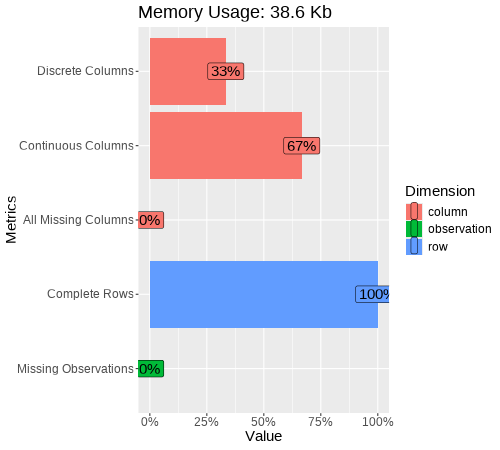

In [15]:
%%R -w 500 -h 450 -u px
mf  |>
  DataExplorer::plot_intro()


Distribution of the `count` variable in `mined` setting is shown below

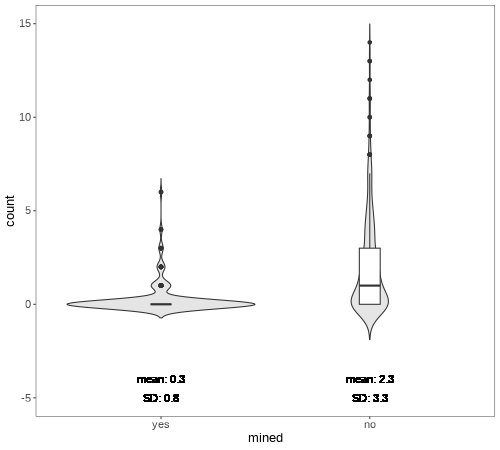

In [14]:
%%R -w 500 -h 450 -u px
# output the results
mf %>%
  # prepare data
  dplyr::select(mined, count) %>%
  dplyr::group_by(mined) %>%
  dplyr::mutate(Mean = round(mean(count), 1)) %>%
  dplyr::mutate(SD = round(sd(count), 1)) %>%
  # start plot
  ggplot(aes(mined, count, color = mined, fill = mined)) +
  geom_violin(trim=FALSE, color = "gray20")+
  geom_boxplot(width=0.1, fill="white", color = "gray20") +
  geom_text(aes(y=-4,label=paste("mean: ", Mean, sep = "")), size = 3, color = "black") +
  geom_text(aes(y=-5,label=paste("SD: ", SD, sep = "")), size = 3, color = "black") +
  scale_fill_manual(values=rep("grey90",4)) +
  theme_set(theme_bw(base_size = 10)) +
  theme(legend.position="none", legend.title = element_blank(),
        panel.grid.major = element_blank(),
        panel.grid.minor = element_blank()) +
  ylim(-5, 15) +
  labs(x = "mined", y = "count")


### Goodness-of-fit Tests

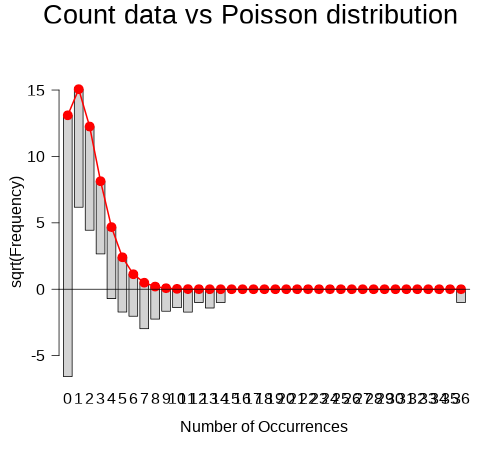

In [17]:
%%R -w 500 -h 450 -u px
gf = vcd::goodfit(mf$count,type= "poisson", method= "ML")
plot(gf, main="Count data vs Poisson distribution")


The data does not perfectly match a Poisson distribution. We will use a goodness-of-fit test to determine if it significantly diverges from this distribution. A p-value less than .05 indicates a significant difference, suggesting the data is likely over-dispersed.

In [18]:
%%R
summary(gf)


	 Goodness-of-fit test for poisson distribution

                      X^2 df      P(> X^2)
Likelihood Ratio 958.8815 14 1.032889e-195


The p-value is indeed smaller than .05 which means that we should indeed use a negative-binomial model rather than a Poisson model. We will ignore this, for now, and proceed to fit a Poisson mixed-effects model and check what happens if a Poisson model is fit to over-dispersed data.

### Mixed Effect Poisson Models

To analyze the **Salamanders** dataset from the `{glmmTMB}` package using different types of Poisson models with the `{lme4}` package, you can follow these steps. Here's a detailed approach to fit fixed-effects, random-effects, and nested random-effects Poisson models.

We will fit the following models to the Salamanders dataset to model the count of salamanders observed using the `cover`, `mined` and `spp` variables:

#### Fixed-Effects Poisson Model

This model assumes only fixed effects without any grouping structure.


In [19]:
%%R
# Fixed-effects Poisson model
model_fixed <- glm(count ~ mined + spp + cover, data = mf, family = "poisson")
summary(model_fixed)


Call:
glm(formula = count ~ mined + spp + cover, family = "poisson", 
    data = mf)

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.49204    0.14129 -10.560  < 2e-16 ***
minedno      2.29902    0.12005  19.151  < 2e-16 ***
sppPR       -1.38629    0.21517  -6.443 1.17e-10 ***
sppDM        0.23052    0.12889   1.789   0.0737 .  
sppEC-A     -0.77011    0.17105  -4.502 6.73e-06 ***
sppEC-L      0.62117    0.11931   5.206 1.92e-07 ***
sppDES-L     0.67916    0.11813   5.749 8.96e-09 ***
sppDF        0.08004    0.13344   0.600   0.5486    
cover       -0.23087    0.04136  -5.582 2.37e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1

(Dispersion parameter for poisson family taken to be 1)

    Null deviance: 2120.7  on 643  degrees of freedom
Residual deviance: 1278.9  on 635  degrees of freedom
AIC: 2020.1

Number of Fisher Scoring iterations: 6



#### Random-Intercept Model

This model includes a random intercept for the `site`.

In [20]:
%%R
# Random-intercept Poisson model
model_random_intercept <- glmer(count ~ mined + spp + cover + (1 | site),
                                data = Salamanders, family = "poisson")
summary(model_random_intercept)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: count ~ mined + spp + cover + (1 | site)
   Data: Salamanders

     AIC      BIC   logLik deviance df.resid 
  1964.3   2009.0   -972.1   1944.3      634 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.6063 -0.7421 -0.4244  0.0778 11.6872 

Random effects:
 Groups Name        Variance Std.Dev.
 site   (Intercept) 0.3175   0.5635  
Number of obs: 644, groups:  site, 23

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.68944    0.25581  -6.604 4.00e-11 ***
minedno      2.39498    0.33283   7.196 6.21e-13 ***
sppPR       -1.38629    0.21417  -6.473 9.63e-11 ***
sppDM        0.23050    0.12830   1.797   0.0724 .  
sppEC-A     -0.77013    0.17027  -4.523 6.10e-06 ***
sppEC-L      0.62115    0.11876   5.230 1.69e-07 ***
sppDES-L     0.67914    0.11758   5.776 7.66e-09 ***
sppDF        0.08004    0.13283   0.603   0

#### Random-Intercept and Slope Model

This model includes a random slope for `mined` within `site`.   


In [21]:
%%R
# Random-intercept and slope Poisson model
model_random_slope <- glmer(count ~ mined + spp + cover + (mined | site),
                            data = mf, family = "poisson")
summary(model_random_slope)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: count ~ mined + spp + cover + (mined | site)
   Data: mf

     AIC      BIC   logLik deviance df.resid 
  1951.4   2005.0   -963.7   1927.4      632 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.5719 -0.7403 -0.3875  0.0571 11.9113 

Random effects:
 Groups Name        Variance Std.Dev. Corr 
 site   (Intercept) 1.170    1.082         
        minedno     1.411    1.188    -0.99
Number of obs: 644, groups:  site, 23

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -1.98239    0.38025  -5.213 1.85e-07 ***
minedno      2.78291    0.38356   7.255 4.00e-13 ***
sppPR       -1.38764    0.21434  -6.474 9.54e-11 ***
sppDM        0.22983    0.12834   1.791 0.073337 .  
sppEC-A     -0.77091    0.17035  -4.525 6.03e-06 ***
sppEC-L      0.62020    0.11880   5.220 1.79e-07 ***
sppDES-L     0.67823    0.11763   5.766 8.12e

#### Nested Random-Effects Model

This model includes `spp` nested within `site`.

In [22]:
%%R
model_nested <- glmer(count ~ mined + cover+ spp+ (1 | site / spp),
                      data = mf, family = "poisson")
summary(model_nested)

Generalized linear mixed model fit by maximum likelihood (Laplace
  Approximation) [glmerMod]
 Family: poisson  ( log )
Formula: count ~ mined + cover + spp + (1 | site/spp)
   Data: mf

     AIC      BIC   logLik deviance df.resid 
  1771.2   1820.4   -874.6   1749.2      633 

Scaled residuals: 
    Min      1Q  Median      3Q     Max 
-2.2697 -0.6227 -0.3389  0.0853  5.8701 

Random effects:
 Groups   Name        Variance Std.Dev.
 spp:site (Intercept) 0.7380   0.8591  
 site     (Intercept) 0.2582   0.5081  
Number of obs: 644, groups:  spp:site, 161; site, 23

Fixed effects:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.15026    0.36033  -5.967 2.41e-09 ***
minedno      2.47549    0.36686   6.748 1.50e-11 ***
cover       -0.06995    0.17936  -0.390 0.696525    
sppPR       -1.35817    0.39416  -3.446 0.000569 ***
sppDM        0.42274    0.33186   1.274 0.202714    
sppEC-A     -0.61106    0.35810  -1.706 0.087932 .  
sppEC-L      0.54770    0.33040   1.658 0.

#### Model Comparison

Now we compare the models with AIC to determine the best-fitting model.


In [ ]:
%%R
AIC(model_fixed, model_random_intercept, model_random_slope, model_nested)

Likelihood ratio tests of cumulative link models:
 
     formula:                                                link:  threshold: 
m_01 SURENESS ~ (1 | RESP)                                   probit equidistant
m_02 SURENESS ~ PROD + GENDER + (1 | RESP)                   probit equidistant
m_03 SURENESS ~ PROD + GENDER + (1 | RESP) + (1 | RESP:PROD) probit equidistant

     no.par    AIC  logLik LR.stat df Pr(>Chisq)    
m_01      3 5726.6 -2860.3                          
m_02      5 5554.7 -2772.3 175.976  2  < 2.2e-16 ***
m_03      6 5538.6 -2763.3  18.025  1   2.18e-05 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


We can also use the `anova()` function to compare the models using a likelihood ratio test.

In [23]:
%%R
anova(model_fixed, model_random_intercept, model_random_slope, model_nested)

Analysis of Deviance Table

Model: poisson, link: log

Response: count

Terms added sequentially (first to last)


      Df Deviance Resid. Df Resid. Dev  Pr(>Chi)    
NULL                    643     2120.7              
mined  1   545.44       642     1575.2 < 2.2e-16 ***
spp    6   264.89       636     1310.3 < 2.2e-16 ***
cover  1    31.47       635     1278.9 2.023e-08 ***
---
Signif. codes:  0 ‘***’ 0.001 ‘**’ 0.01 ‘*’ 0.05 ‘.’ 0.1 ‘ ’ 1


Nexted model is the best fit model based on AIC and likelihood ratio test.

#### Model Summary

`jtolls::summ()` function provides a concise summary of the model results, including the fixed effects, random effects, and model fit statistics.

In [24]:
%%R
jtools::summ(model_nested)

MODEL INFO:
Observations: 644
Dependent Variable: count
Type: Mixed effects generalized linear regression
Error Distribution: poisson
Link function: log 

MODEL FIT:
AIC = 1771.21, BIC = 1820.36
Pseudo-R² (fixed effects) = 0.46
Pseudo-R² (total) = 0.70 

FIXED EFFECTS:
------------------------------------------------
                     Est.   S.E.   z val.      p
----------------- ------- ------ -------- ------
(Intercept)         -2.15   0.36    -5.97   0.00
minedno              2.48   0.37     6.75   0.00
cover               -0.07   0.18    -0.39   0.70
sppPR               -1.36   0.39    -3.45   0.00
sppDM                0.42   0.33     1.27   0.20
sppEC-A             -0.61   0.36    -1.71   0.09
sppEC-L              0.55   0.33     1.66   0.10
sppDES-L             0.84   0.33     2.57   0.01
sppDF                0.35   0.33     1.04   0.30
------------------------------------------------

RANDOM EFFECTS:
------------------------------------
  Group      Parameter    Std. Dev. 
--

#### Model Performance

`performance::performance()` function provides a summary of the model performance, including the AIC, BIC, and other fit statistics.

In [25]:
%%R
performance::performance(model_nested)

# Indices of model performance

AIC      |     AICc |      BIC | R2 (cond.) | R2 (marg.) |   ICC |  RMSE | Sigma | Score_log | Score_spherical
--------------------------------------------------------------------------------------------------------------
1771.211 | 1771.629 | 1820.356 |      0.881 |      0.582 | 0.715 | 1.778 | 1.000 |    -1.130 |           0.033


The $R^2$ values of the are incorrect (as indicated by the missing conditional $R^2$ value). The more appropriate conditional and marginal coefficient of determination for generalized mixed-effect models can be extracted using the `r.squaredGLMM ()` function from the {MuMIn} package (Barton 2020).


In [26]:
%%R
MuMIn::r.squaredGLMM(model_nested)

                R2m       R2c
delta     0.5662048 0.8572292
lognormal 0.5816332 0.8805877
trigamma  0.5442529 0.8239942


#### Marginal Effects and Adjusted Predictions

`plot_model()` of {sjPlot} creates plots from regression models, either estimates (as so-called forest or dot whisker plots) or marginal effects.

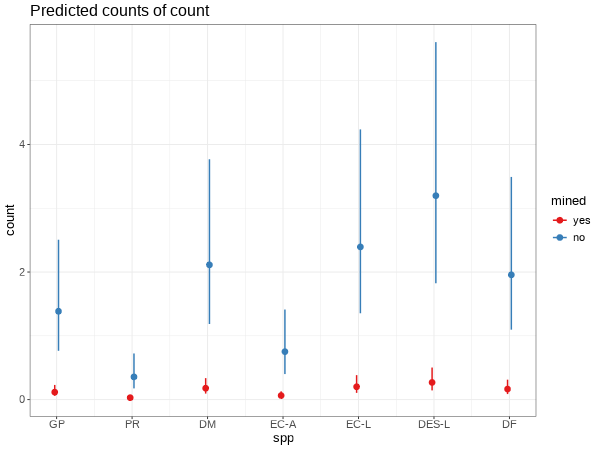

In [27]:
%%R -w 600 -h 450 -u px
plot_model(model_nested, type = "pred", terms = c("spp", "mined"), show.values = TRUE)

### Mixed-Effect Models for Overdispersed Count Data

When analyzing count data, overdispersion is a common issue where the variance of the outcome variable exceeds the mean. This can lead to biased parameter estimates and incorrect inferences if not properly addressed. In this section, we will demonstrate how to fit mixed-effects regression models for overdispersed count data. First we check for overdispersion in the Poisson model and then adjust for overdispersion using the quasi-Poisson approximation or fit a negative binomial model as an alternative.



#### Check for Overdispersion

Check for overdispersion of `model_nested` by calculating the ratio of the residual deviance to the degrees of freedom:

In [28]:
%%R
# Check overdispersion
overdispersion_ratio <- sum(residuals(model_nested, type = "pearson")^2) / df.residual(model_nested)
cat("Overdispersion ratio:", overdispersion_ratio, "\n")

Overdispersion ratio: 1.153974 


-   If the overdispersion ratio is significantly greater than 1, overdispersion is present.

Or we can use the `performance::check_overdispersion()` function to check for overdispersion in the `model_nested`.

In [29]:
%%R
performance::check_overdispersion(model_nested)

# Overdispersion test

       dispersion ratio =   1.154
  Pearson's Chi-Squared = 730.465
                p-value =   0.004



#### Adjust for Overdispersion in the Poisson Model (Quasi-Poisson Approximation)

The **quasi-Poisson** approach is used to handle overdispersion (variance greater than the mean) in count data. However, the `{lme4}` package does not directly support quasi-Poisson models because it is based on maximum likelihood estimation (which does not accommodate quasi-likelihood models). To address overdispersion in a Poisson model, we can adjust the standard errors post hoc using the overdispersion ratio.


In [30]:
%%R
# Adjust standard errors for overdispersion
se_adjusted <- sqrt(overdispersion_ratio) * sqrt(diag(vcov(model_nested)))
coef_table <- summary(model_nested)$coefficients
coef_table[, 2] <- se_adjusted  # Replace standard errors
coef_table[, 3] <- coef_table[, 1] / coef_table[, 2]  # Recompute z-values
coef_table[, 4] <- 2 * (1 - pnorm(abs(coef_table[, 3])))  # Recompute p-values

cat("Adjusted Coefficients Table:\n")
print(coef_table)

Adjusted Coefficients Table:
               Estimate Std. Error    z value     Pr(>|z|)
(Intercept) -2.15025576  0.3870788 -5.5550860 2.774751e-08
minedno      2.47548850  0.3940971  6.2814174 3.355001e-10
cover       -0.06995383  0.1926759 -0.3630648 7.165565e-01
sppPR       -1.35817326  0.4234143 -3.2076696 1.338151e-03
sppDM        0.42274244  0.3564945  1.1858315 2.356889e-01
sppEC-A     -0.61106262  0.3846805 -1.5884939 1.121747e-01
sppEC-L      0.54769788  0.3549292  1.5431188 1.228020e-01
sppDES-L     0.83686853  0.3491799  2.3966689 1.654487e-02
sppDF        0.34574647  0.3582845  0.9650054 3.345421e-01


#### Fit Quasi-Poisson Model

To account for overdispersion, fit a quasi-Poisson model using the `glmmPQL()` function of {MASS} package. The quasi-Poisson model is a generalized linear mixed model that relaxes the assumption of equal mean and variance in Poisson regression, making it suitable for overdispersed count data.

In [31]:
%%R
# Quasi-Poisson mixed-effects model
model_quasi_poisson <- MASS::glmmPQL(count ~ mined + spp + cover,  random = ~1 | site,
                             data = mf, family = quasipoisson(link='log'))
summary(model_quasi_poisson)

Linear mixed-effects model fit by maximum likelihood
  Data: mf 
  AIC BIC logLik
   NA  NA     NA

Random effects:
 Formula: ~1 | site
        (Intercept) Residual
StdDev:   0.2888095   1.5873

Variance function:
 Structure: fixed weights
 Formula: ~invwt 
Fixed effects:  count ~ mined + spp + cover 
                 Value Std.Error  DF   t-value p-value
(Intercept) -1.4630935 0.2478870 615 -5.902259  0.0000
minedno      2.2211941 0.2489954  20  8.920625  0.0000
sppPR       -1.3862944 0.3439443 615 -4.030578  0.0001
sppDM        0.2305237 0.2060291 615  1.118889  0.2636
sppEC-A     -0.7701082 0.2734303 615 -2.816470  0.0050
sppEC-L      0.6211737 0.1907148 615  3.257082  0.0012
sppDES-L     0.6791609 0.1888278 615  3.596722  0.0003
sppDF        0.0800427 0.2133052 615  0.375250  0.7076
cover       -0.1686904 0.1105425  20 -1.526023  0.1427
 Correlation: 
         (Intr) minedn sppPR  sppDM  spEC-A spEC-L sDES-L sppDF 
minedno  -0.722                                                 
sp

#### Fit a Negative Binomial Model (Alternative for Overdispersion)

Negative binomial regression models extend the framework of Poisson regression by addressing a critical limitation inherent in the Poisson approach: the assumption that the variance of the outcome variable is equal to its mean. This assumption can often lead to poor model fit, especially when the data exhibit **overdispersion** — where the observed variance significantly exceeds the mean. By allowing for greater flexibility in modeling the relationship between the dependent and independent variables, negative binomial regression provides a robust alternative when dealing with count data that do not conform to the strict requirements of the Poisson distribution, making it particularly useful in real-world scenarios where data often show considerable variability.

A **negative binomial model** can handle overdispersion more directly. First we  use `{glmmTMB}` to fit a negative binomial models. Two parameterisations are often used to fit negative binomial regression models (see Hilbe (2011Hilbe, Joseph M. 2011. *Negative Binomial Regression*. Cambridge University Press. <https://doi.org/10.1017/CBO9780511973420>.)):

(a) *NB1* (variance = $μ$ + $αμ$); and,

(b) *NB2* (variance = $μ+αμ^2$); where $μ$ is the mean, and αα is the overdispersion parameter


##### NB1 Parameterization


In [33]:
%%R
# Negative binomial mixed-effects model
model_negbinom_01 <- glmmTMB(count ~ mined + spp + cover+(1 | site / spp),
                          data = mf,
                          family = nbinom1)
# model summary
summary(model_negbinom_01)

 Family: nbinom1  ( log )
Formula:          count ~ mined + spp + cover + (1 | site/spp)
Data: mf

     AIC      BIC   logLik deviance df.resid 
  1629.9   1683.5   -802.9   1605.9      632 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 spp:site (Intercept) 0.3073   0.5544  
 site     (Intercept) 0.1647   0.4059  
Number of obs: 644, groups:  spp:site, 161; site, 23

Dispersion parameter for nbinom1 family (): 1.49 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  -1.6532     0.3070  -5.386 7.22e-08 ***
minedno       2.2005     0.3058   7.197 6.16e-13 ***
sppPR        -1.3761     0.3633  -3.788 0.000152 ***
sppDM         0.3283     0.2734   1.201 0.229783    
sppEC-A      -0.7819     0.3222  -2.427 0.015221 *  
sppEC-L       0.4735     0.2687   1.762 0.078099 .  
sppDES-L      0.7033     0.2649   2.655 0.007923 ** 
sppDF         0.2610     0.2770   0.942 0.346101    
cover        -0.1140     0.1475  -0.773 0.439301   

##### NB2 Parameterization

In [34]:
%%R
#| message: false
#| error: false
# Negative binomial mixed-effects model
model_negbinom_02 <- glmmTMB(count ~ mined + spp + cover+(1 | site / spp),
                          data = mf,
                          family = nbinom2)


# model summary
summary(model_negbinom_02)

 Family: nbinom2  ( log )
Formula:          count ~ mined + spp + cover + (1 | site/spp)
Data: mf

     AIC      BIC   logLik deviance df.resid 
  1650.0   1703.6   -813.0   1626.0      632 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 spp:site (Intercept) 0.5600   0.7483  
 site     (Intercept) 0.2683   0.5180  
Number of obs: 644, groups:  spp:site, 161; site, 23

Dispersion parameter for nbinom2 family (): 1.67 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.06868    0.35949  -5.754 8.69e-09 ***
minedno      2.46956    0.36903   6.692 2.20e-11 ***
sppPR       -1.35107    0.38895  -3.474 0.000513 ***
sppDM        0.42454    0.32716   1.298 0.194398    
sppEC-A     -0.61800    0.35345  -1.748 0.080382 .  
sppEC-L      0.55120    0.32545   1.694 0.090326 .  
sppDES-L     0.83912    0.32031   2.620 0.008801 ** 
sppDF        0.35093    0.32904   1.067 0.286191    
cover       -0.07243    0.18063  -0.401 0.688424   

In [35]:
%%R
anova(model_negbinom_01, model_negbinom_02)

Data: mf
Models:
model_negbinom_01: count ~ mined + spp + cover + (1 | site/spp), zi=~0, disp=~1
model_negbinom_02: count ~ mined + spp + cover + (1 | site/spp), zi=~0, disp=~1
                  Df    AIC    BIC  logLik deviance Chisq Chi Df Pr(>Chisq)
model_negbinom_01 12 1629.9 1683.5 -802.93   1605.9                        
model_negbinom_02 12 1650.0 1703.6 -812.99   1626.0     0      0          1


In [36]:
%%R
MuMIn::r.squaredGLMM(model_negbinom_02)

                R2m       R2c
delta     0.5021432 0.7178595
lognormal 0.5524042 0.7897121
trigamma  0.4184650 0.5982339


##### Using `lme4` Package

We also fit a negative binomial mode using `glmer.nb()` of {lme4}  package but it may be slower and unstable compared to {glmmTMB} package.

In [37]:
%%R
# Negative binomial mixed-effects model
model_negbinom_03 <- glmer.nb(count ~ mined + spp + cover+(1 | site / spp),
                          data = mf)
jtools::summ(model_negbinom_03)

MODEL INFO:
Observations: 644
Dependent Variable: count
Type: Mixed effects generalized linear regression
Error Distribution: Negative Binomial(1.666)
Link function: log 

MODEL FIT:
AIC = 1648.59, BIC = 1702.20
Pseudo-R² (fixed effects) = 0.48
Pseudo-R² (total) = 0.69 

FIXED EFFECTS:
------------------------------------------------
                     Est.   S.E.   z val.      p
----------------- ------- ------ -------- ------
(Intercept)         -2.10   0.36    -5.87   0.00
minedno              2.44   0.36     6.72   0.00
sppPR               -1.34   0.39    -3.44   0.00
sppDM                0.42   0.33     1.29   0.20
sppEC-A             -0.61   0.35    -1.73   0.08
sppEC-L              0.55   0.33     1.68   0.09
sppDES-L             0.83   0.32     2.60   0.01
sppDF                0.35   0.33     1.06   0.29
cover               -0.07   0.18    -0.40   0.69
------------------------------------------------

RANDOM EFFECTS:
------------------------------------
  Group      Parameter

### Zero-inflated Mixed Effect Models

Zero-inflated models are used to account for excess zeros in count data, which can arise due to a separate process that generates zeros (e.g., structural zeros) in addition to the count process. In zero-inflated models, the data are assumed to come from two different processes: one that generates zeros and one that generates counts. The zero-inflated Poisson model is a mixture model that combines a Poisson distribution for the count data with a point mass at zero for the excess zeros.



#### Check for `zero-inflation` and `overdispersion` in the model

We can use the `performance::check_zeroinflation()` function to check for zero-inflation in the nested model (`model_nested`).

In [38]:
%%R
performance::check_zeroinflation(model_nested)

# Check for zero-inflation

   Observed zeros: 387
  Predicted zeros: 341
            Ratio: 0.88



#### Fit Zero-Inflated Negative Binomial Model

we can also use the `glmmTMB::glmmTMB()` function to fit a zero-inflated negative binomila  mixed-effects model to the Salamanders dataset.

In [39]:
%%R
# Zero-inflated negative binomial mixed-effects model
model_zinb <- glmmTMB(count ~ mined + spp + cover + (1 | site / spp),
                      data = mf,
                      family = nbinom2,
                      ziformula = ~1)
# Summary of the model
summary(model_zinb)

 Family: nbinom2  ( log )
Formula:          count ~ mined + spp + cover + (1 | site/spp)
Zero inflation:         ~1
Data: mf

     AIC      BIC   logLik deviance df.resid 
  1652.0   1710.1   -813.0   1626.0      631 

Random effects:

Conditional model:
 Groups   Name        Variance Std.Dev.
 spp:site (Intercept) 0.5600   0.7483  
 site     (Intercept) 0.2683   0.5180  
Number of obs: 644, groups:  spp:site, 161; site, 23

Dispersion parameter for nbinom2 family (): 1.67 

Conditional model:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept) -2.06871    0.35950  -5.754 8.69e-09 ***
minedno      2.46955    0.36903   6.692 2.20e-11 ***
sppPR       -1.35104    0.38895  -3.474 0.000514 ***
sppDM        0.42456    0.32716   1.298 0.194376    
sppEC-A     -0.61797    0.35345  -1.748 0.080398 .  
sppEC-L      0.55124    0.32545   1.694 0.090307 .  
sppDES-L     0.83915    0.32031   2.620 0.008799 ** 
sppDF        0.35096    0.32904   1.067 0.286152    
cover       -0.07243    

In [40]:
%%R
MuMIn::r.squaredGLMM(model_zinb)

                R2m       R2c
delta     0.5021432 0.7178590
lognormal 0.5524043 0.7897118
trigamma  0.4184648 0.5982332


## Summary and Conclusion

This tutorial has thoroughly introduced mixed-effects Poisson models, emphasizing their application in analyzing count data while accounting for both fixed and random effects. We begin by constructing a Mixed-Effects Poisson Model from scratch without relying on external libraries. Next, we fit various types of Poisson models using the {lme4}, {glmmTMB}, and {MASS} packages. The {lme4} package is utilized to fit random-effects Poisson models of varying complexity, including random intercept models, random intercept and slope models, and nested random-effects models. The {glmmTMB} package provides enhanced capabilities by fitting negative binomial models to address overdispersion, a common issue with Poisson data. Finally, the {MASS} package demonstrates how to fit quasi-Poisson and negative binomial models as alternatives for handling overdispersion, offering more flexible modeling approaches.

This tutorial explored mixed-effect Poisson modeling, from manual implementation to leveraging powerful R packages. For most practical applications, begin with {lme4} for basic mixed-effects Poisson models. For datasets with overdispersion or more complex structures, consider {glmmTMB} or {MASS} for extended modeling capabilities. By mastering these techniques, you can effectively analyze count data with hierarchical structures, making informed inferences and predictions in various fields such as biostatistics, epidemiology, and ecology.


## References

1.  [Mixed-Effects (Quasi-)Poisson and Negative-Binomial Regression](https://ladal.edu.au/regression.html#Poisson_Regression)

2.  [Modeling Count Outcome using the Generalized Multilevel Model](https://quantdev.ssri.psu.edu/tutorials/apa-ati-intensive-longitudinal-data-session-j-generalized-multilevel-model-poisson)

3.  [Modelling Count Data in R: A Multilevel Framework](https://fcorowe.github.io/countdata_modelling/)

4.  [Multilevel Poisson Regression](https://stats.idre.ucla.edu/r/dae/multilevel-poisson-regression/)



